## 1. Mount google drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 2. Append Path and change directory

In [5]:
import os
import sys

sys.path.append('/content/gdrive/My Drive/ISS/data/PLP/')

os.chdir('/content/gdrive/My Drive/ISS/data/PLP/')
print("Current working directory:")
os.getcwd()

Current working directory:


'/content/gdrive/My Drive/ISS/data/PLP'

## 3. Import the libraries

In [6]:
# install dependencies

!pip install vaderSentiment
!pip install squarify

     |████████████████████████████████| 125 kB 5.2 MB/s 


In [7]:
# import libraries

import nltk
import spacy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#import squarify
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, FreqDist, sent_tokenize
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud,STOPWORDS

## 4. Data preparation

In [8]:
# loading from file
df = pd.read_csv("googleplaystore_user_reviews.csv") #, engine='python'
df.head(5)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


## 5. Common Functions

In [9]:
# remove non value in text and sentiment column
def filter_non(data):
  data = data[data.Sentiment.notnull()]
  data = data[data.Translated_Review.notnull()]

  # drop the neutral records, only differentiate positive and negative comments
  data = data[data.Sentiment != "Neutral"]
  return data

# remove words which length less than 2
def preprocess(words) :
  words_clean = [w.lower() for w in words.split() if len(w) >= 3]
  words_clean = [ w for w in words_clean if not w.isdigit() ]

  return words_clean

# draw word cloud
def wordcloud_draw(data):
    words = ' '.join(data)
    cleaned_word = " ".join([w for w in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def get_polarity(text):
    score = analyzer.polarity_scores(text)
    return 'Positive' if score['pos'] > score['neg'] else 'Negative'

## 6. Processing training data

In [10]:
# 1. filter non rows
df = filter_non(df)

df.head(10)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.000000,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.250000,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.400000,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.000000,0.300000
5,10 Best Foods for You,Best way,Positive,1.000000,0.300000
6,10 Best Foods for You,Amazing,Positive,0.600000,0.900000
10,10 Best Foods for You,good you.,Positive,0.700000,0.600000
11,10 Best Foods for You,Useful information The amount spelling errors ...,Positive,0.200000,0.100000
12,10 Best Foods for You,"Thank you! Great app!! Add arthritis, eyes, im...",Positive,0.750000,0.875000
13,10 Best Foods for You,Greatest ever Completely awesome maintain heal...,Positive,0.992188,0.866667


In [11]:
from sklearn.model_selection import train_test_split

# split data training/test
#X_train, X_test, y_train, y_test = train_test_split(df["Translated_Review"], df["Sentiment"], test_size=0.3, random_state=40)

train, test = train_test_split(df, test_size=0.3, random_state=40)

# train data
X_train, y_train = train["Translated_Review"], train["Sentiment"]
 
# test data
X_test, y_test = test["Translated_Review"], test["Sentiment"]

## 7. Explore Data

Positive words


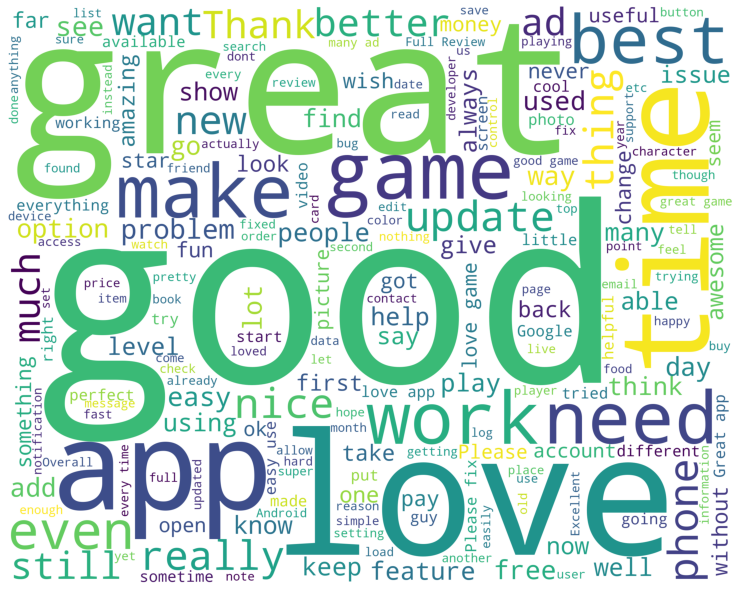

In [9]:
train_pos = train[train['Sentiment'] == 'Positive']
train_pos = train_pos['Translated_Review']

print("Positive words")
wordcloud_draw(train_pos)

Negative words


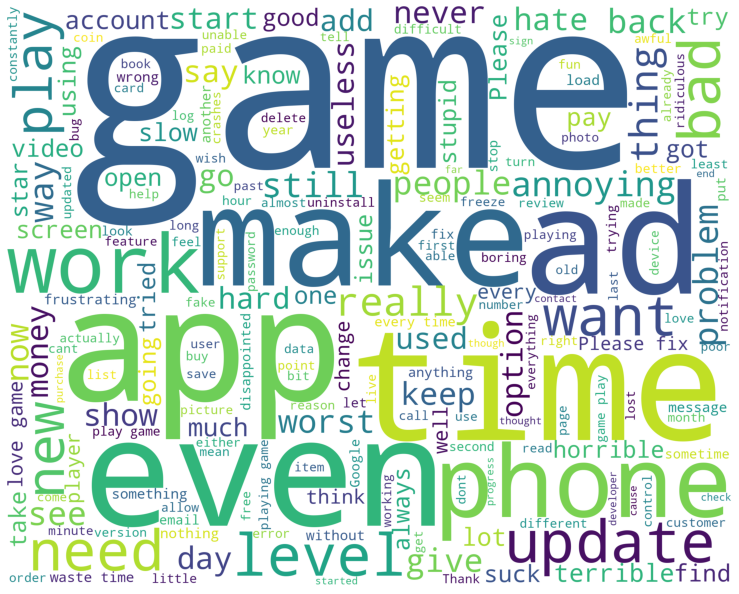

In [10]:
train_neg = train[train['Sentiment'] == 'Negative']
train_neg = train_neg['Translated_Review']

print("Negative words")
wordcloud_draw(train_neg)

# 8.0 Unigram classifier



In [11]:
from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# punctuation
nltk.download('punkt')

# stop words
nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
clf = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   #tokenizer=word_tokenize,
                                   tokenizer=lambda text: mark_negation(word_tokenize(text)),
                                   max_features=10000)),
    ('classifier', LinearSVC())
])
 
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.935613144536468

Conclution: negation do not help to much

# 8.1 Bigram classifier

this solution doesn't help to our data

In [ ]:
bigram_clf = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   #tokenizer=word_tokenize,
                                   ngram_range=(2, 2),
                                   tokenizer=lambda text: mark_negation(word_tokenize(text)),
                                   max_features=10000)),
    ('classifier', LinearSVC())
])
 
bigram_clf.fit(X_train, y_train)
bigram_clf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7584825006679135

# 8.2 Unigram and Bigram classifier

In [ ]:
ub_clf = Pipeline([
    ('vectorizer', CountVectorizer(analyzer="word",
                                   tokenizer=word_tokenize,
                                   ngram_range=(1, 2),
                                   #tokenizer=lambda text: mark_negation(word_tokenize(text)),
                                   max_features=10000)),
    ('classifier', LinearSVC())
])
 
ub_clf.fit(X_train, y_train)
ub_clf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9343663727847538

without negation: 0.9343663727847538<br>
with negation: 0.9283996794015495

# 8.3 NLTK VADER Sentiment Intensity Analyzer

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

nlp_spacy = spacy.load('en_core_web_sm')
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
analyzer = SentimentIntensityAnalyzer()

y_pred = [get_polarity(text) for text in X_test]
accuracy_score(y_test, y_pred)

0.7115504497283819

## 9.0 Using word2vec, MeanEmbedding and GLOVE Feature


In [ ]:
def load_golve(file):
  glove_small = {}

  with open(file, "rb") as infile:
      for line in infile:
          parts = line.split()
          word = parts[0].decode("utf-8")
          if (word in all_words):
              nums=np.array(parts[1:], dtype=np.float32)
              glove_small[word] = nums
  return glove_small

In [ ]:
import re 

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            print(len(word2vec))
            self.dim=len(word2vec[next(iter(glove_small))])
            #self.dim=len(word2vec["and"])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


In [ ]:
# loading glove file
glove_small = load_golve("glove.6B.100d.txt")

# convert training and testing data
X_train_glove = 
X_test_glove = 

In [ ]:
glove_Embedding = MeanEmbeddingVectorizer(glove_small)

X_glove_train = glove_Embedding.transform(X_train)
X_glove_test = glove_Embedding.transform(X_test)

In [ ]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(X, size=100, window=5, min_count=2, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.vectors)}

w2v_Embedding = MeanEmbeddingVectorizer(w2v)

X_w2v_train = w2v_Embedding.transform(X_train)
X_w2v_test = w2v_Embedding.transform(X_test)

In [ ]:
# KBest
# using tfidf vectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1)
train_vectors = vectorizer.fit_transform(X_nega_train)
test_vectors = vectorizer.transform(X_nega_test)

ch21 = SelectKBest(chi2, k=100)

train_Kbest = ch21.fit_transform(train_vectors, Y_nega_train)
test_Kbest = ch21.transform(test_vectors)

In [ ]:
final_train = np.c_[X_w2v_train, X_glove_train, train_Kbest.todense()]
final_test = np.c_[X_w2v_test, X_glove_test, test_Kbest.todense()]

In [ ]:
model_svm = LinearSVC(C=1.0)

sv = model_svm.fit(final_train, y_train)

y_pred_svm= sv.predict(final_test)

metrics.classification_report(y_test, list(y_pred_svm))

# 10.0 Using Spacy to do sentiment analysis

In [14]:
def convert_spacy(data):
  data_spacy = []
  for index, row in data.iterrows():
    cats = {'pos' : False, 'neg': False}
    if data['Sentiment'].loc[index] == 'Positive':
      cats['pos'] = True
    else:
      cats['neg'] = True
    temp = {"cats" : cats}

    data_spacy.append((data['Translated_Review'].loc[index], temp))

  return data_spacy

In [15]:
train_data_spacy = convert_spacy(train)
train_data_spacy[:5]

[('This game reminds gradius when I younger. As family, used stay home compete night. Like championship game. Best memories!',
  {'cats': {'neg': False, 'pos': True}}),
 ('Awesome', {'cats': {'neg': False, 'pos': True}}),
 ('Dino Hunter:Deadly Shores great game takes back stone age dinosaurs. With great graphic design, beautiful dinosaur design runs pretty smooth would play awesome game one. The game many guns modify, dinosaurs modes explore. Similar "Deer Hunter" big better atmosphere TV game. Overall fun game recommend it!',
  {'cats': {'neg': False, 'pos': True}}),
 ('Not great , credit score lowers reason',
  {'cats': {'neg': True, 'pos': False}}),
 ('Nice Should try it.', {'cats': {'neg': False, 'pos': True}})]

In [16]:
test_data_spacy = convert_spacy(test)
test_data_spacy[:5]

[('I watch commercials view list episodes available? Come',
  {'cats': {'neg': False, 'pos': True}}),
 ('sucks compared apt finder', {'cats': {'neg': False, 'pos': True}}),
 ('The content well curated, I give credit due. However, search feed frustratingly slow. So want find specific books, goooood luck scrolling thru dozens hundreds titles MAYBE finding want. Why search feature? Why titles load slowly?',
  {'cats': {'neg': True, 'pos': False}}),
 ("This works perfectly fine phone partners phone can't located 99% time I look location history later good I can't find he's current time",
  {'cats': {'neg': False, 'pos': True}}),
 ("Love game I'm issues requesting gifts club advise I restarted phone closed opened even checked updates. Any help would great worked fine today",
  {'cats': {'neg': False, 'pos': True}})]

## 10.1 Process sentence

In [17]:
import random
from spacy.util import minibatch, compounding

def train_model(
    training_data: list,
    test_data: list,
    iterations: int = 20
) -> None:
    # Build pipeline
    nlp = spacy.load('en_core_web_sm')
    if "textcat" not in nlp.pipe_names:
        textcat = nlp.create_pipe(
            "textcat", config={"architecture": "simple_cnn"}
        )
        nlp.add_pipe(textcat, last=True)
    else:
        textcat = nlp.get_pipe("textcat")

    textcat.add_label("pos")
    textcat.add_label("neg")

    # Train only textcat
    training_excluded_pipes = [
        pipe for pipe in nlp.pipe_names if pipe != "textcat"
    ]
    with nlp.disable_pipes(training_excluded_pipes):
        optimizer = nlp.begin_training()
        # Training loop
        print("Beginning training")
        print("Loss\tPrecision\tRecall\tF-score")
        batch_sizes = compounding(
            4.0, 32.0, 1.001
        )  # A generator that yields infinite series of input numbers
        for i in range(iterations):
            print(f"Training iteration {i}")
            loss = {}
            random.shuffle(training_data)
            batches = minibatch(training_data, size=batch_sizes)
            for batch in batches:
                text, labels = zip(*batch)
                nlp.update(text, labels, drop=0.2, sgd=optimizer, losses=loss)
            with textcat.model.use_params(optimizer.averages):
                evaluation_results = evaluate_model(
                    tokenizer=nlp.tokenizer,
                    textcat=textcat,
                    test_data=test_data
                )
                print(
                    f"{loss['textcat']}\t{evaluation_results['precision']}"
                    f"\t{evaluation_results['recall']}"
                    f"\t{evaluation_results['f-score']}"
                )

    # Save model
    with nlp.use_params(optimizer.averages):
        nlp.to_disk("nlp_sentiment_model")

def evaluate_model(
    tokenizer, textcat, test_data: list
) -> dict:
    reviews, labels = zip(*test_data)
    reviews = (tokenizer(review) for review in reviews)
    true_positives = 0
    false_positives = 1e-8
    true_negatives = 0
    false_negatives = 1e-8
    for i, review in enumerate(textcat.pipe(reviews)):
        true_label = labels[i]['cats']
        for predicted_label, score in review.cats.items():
            # Every cats dictionary includes both labels. You can get all
            # the info you need with just the pos label.
            if (
                predicted_label == "neg"
            ):
                continue
            if score >= 0.5 and true_label["pos"]:
                true_positives += 1
            elif score >= 0.5 and true_label["neg"]:
                false_positives += 1
            elif score < 0.5 and true_label["neg"]:
                true_negatives += 1
            elif score < 0.5 and true_label["pos"]:
                false_negatives += 1
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    if precision + recall == 0:
        f_score = 0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"precision": precision, "recall": recall, "f-score": f_score}

In [18]:
train_model(train_data_spacy, test_data_spacy, 12)

Beginning training
Loss	Precision	Recall	F-score
Training iteration 0
13.31580195301433	0.9177733065044698	0.9593381940536184	0.9380955645424857
Training iteration 1
0.08655290804290416	0.9426918308293943	0.9594784071775666	0.9510110485707026
Training iteration 2
0.06746426574136422	0.9480286738338185	0.9642456533918056	0.956068399831842
Training iteration 3
0.05762666027862906	0.9497861774024696	0.9653673583833913	0.9575133857159343
Training iteration 4
0.051078804748243556	0.9530710835045506	0.9681716208623553	0.9605620087626617
Training iteration 5
0.043356309467696974	0.9540689655159255	0.9698541783497339	0.9618968154624365
Training iteration 6
0.03958586036088185	0.9570934256042116	0.9695737521018374	0.963293167094848
Training iteration 7
0.03439064033872796	0.9551370811396357	0.9671901289947179	0.9611258185858143
Training iteration 8
0.028869666420064277	0.9534178610791711	0.969994391473682	0.9616346955783129
Training iteration 9
0.027861122333440846	0.9550034506543065	0.97013460

In [25]:
def validate_model(nlp_model, data):
    # Generate prediction
    parsed_text = nlp_model(data)
    # Determine prediction to return
    if parsed_text.cats["pos"] > parsed_text.cats["neg"]:
        prediction = "Positive"
        score = parsed_text.cats["pos"]
    else:
        prediction = "Negative"
        score = parsed_text.cats["neg"]
    #print(f"Review text: {data}\nPredicted sentiment: {prediction}" f"\nScore: {score}")

    return prediction

In [27]:
#  Load saved trained model
nlp_model = spacy.load("nlp_sentiment_model")

validate_model(nlp_model, "Useful information The amount spelling errors questions validity information shared. Once fixed, 5 stars given")

'Positive'

In [ ]:
y_space_pred = [validate_model(text) for text in X_test]

In [ ]:
#accuracy_score(y_test, y_space_pred)


[None, None, None, None, None, None, None, None, None, None]

## Visualize summary result

In [ ]:
#add two new columns into the table
df_summary["category"] = df_summary.index
#represent overall sentiment for the categary based on num of pos/neg
df_summary["sentiment"] = np.round((df_summary["pos"]-df_summary["neg"])/(df_summary["neg"]+df_summary["pos"]),2)

In [ ]:
df_summary

,pos,neg,Total,category,sentiment
overall,24132,4516,28648,overall,0.68
service,1538,904,2442,service,0.26
price,182,48,230,price,0.58
experience,4359,2847,7206,experience,0.21
flight journey,374,70,444,flight journey,0.68


Text(0.5, 1.0, 'Sentiment Heat Map of Restaurant Aspects')

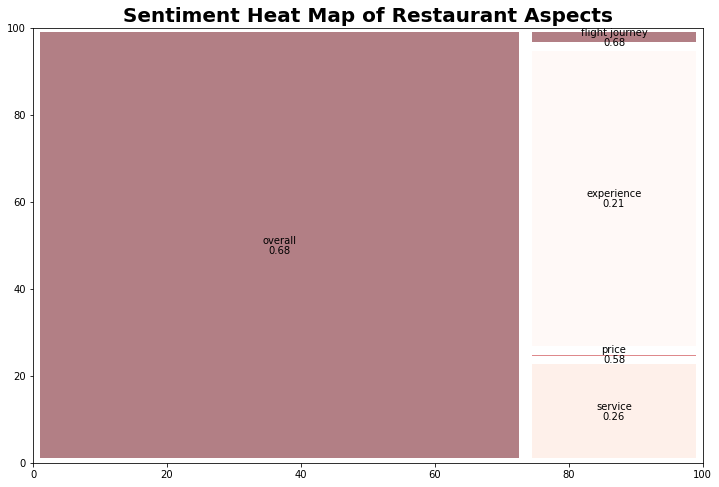

In [ ]:
norm = matplotlib.colors.Normalize(vmin=min(df_summary.sentiment), vmax=max(df_summary.sentiment))
colors = [matplotlib.cm.Reds(norm(value)) for value in df_summary.sentiment]

fig = plt.gcf()
fig.set_size_inches(12, 8)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
# Also used color intensity to reflect the sentiment value. 
squarify.plot(label=df_summary.category, sizes=df_summary.Total, value = df_summary.sentiment, color = colors, alpha=.5, pad =True)
plt.title("Sentiment Heat Map of Restaurant Aspects",fontsize=20,fontweight="bold")

## Using BERT

In [95]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [13]:
!pip install transformers

from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 36.7 MB/s 
     |████████████████████████████████| 895 kB 42.7 MB/s 
     |████████████████████████████████| 596 kB 35.9 MB/s 
     |████████████████████████████████| 59 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [49]:
train_sentences = X_train.values
train_labels = [int(v == 'Positive') for v in y_train.values]

val_sentences = X_test.values
val_labels = [int(v == 'Positive') for v in y_test.values]

In [17]:
max_len = 0

len_arr = []

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

    len_arr.append(len(input_ids))

print('Max sentence length: ', max_len)


Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  640


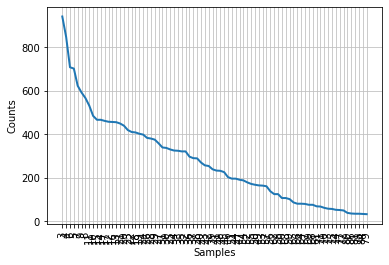

In [30]:
from nltk import FreqDist

fd_len = FreqDist(len_arr)

fd_len.plot(80, cumulative=False)

In [19]:
fd_len.most_common(10)

[(3, 940),
 (4, 846),
 (6, 707),
 (5, 701),
 (7, 622),
 (9, 591),
 (8, 566),
 (11, 531),
 (10, 484),
 (15, 466)]

In [109]:
from torch.utils.data import TensorDataset

def generate_input(input_data, input_labels):
  input_ids = []
  attention_masks = []

  for sent in input_data:
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 100,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # convert to tensors
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  
  if input_labels:
    labels = torch.tensor(input_labels)
    return TensorDataset(input_ids, attention_masks, labels)
  else:
    return TensorDataset(input_ids, attention_masks)

In [45]:
# Combine the training inputs into a TensorDataset.
train_dataset = generate_input(train_sentences, train_labels)

In [50]:
val_dataset = generate_input(val_sentences, val_labels)

In [51]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

In [54]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [55]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

2824


In [61]:
import random
import time
import datetime
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


In [59]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [62]:
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()


# For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += outputs.loss.item()

        # Perform a backward pass to calculate the gradients.
        outputs.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += outputs.loss.item()

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    706.    Elapsed: 0:00:41.
  Batch    80  of    706.    Elapsed: 0:01:22.
  Batch   120  of    706.    Elapsed: 0:02:03.
  Batch   160  of    706.    Elapsed: 0:02:44.
  Batch   200  of    706.    Elapsed: 0:03:24.
  Batch   240  of    706.    Elapsed: 0:04:05.
  Batch   280  of    706.    Elapsed: 0:04:46.
  Batch   320  of    706.    Elapsed: 0:05:27.
  Batch   360  of    706.    Elapsed: 0:06:07.
  Batch   400  of    706.    Elapsed: 0:06:48.
  Batch   440  of    706.    Elapsed: 0:07:29.
  Batch   480  of    706.    Elapsed: 0:08:10.
  Batch   520  of    706.    Elapsed: 0:08:50.
  Batch   560  of    706.    Elapsed: 0:09:31.
  Batch   600  of    706.    Elapsed: 0:10:12.
  Batch   640  of    706.    Elapsed: 0:10:53.
  Batch   680  of    706.    Elapsed: 0:11:33.

  Average training loss: 0.21
  Training epcoh took: 0:12:00

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.14
  Validation took: 0:01:51

====

In [64]:
#Saving your model.
output_file = "./model_bert_ft_cola.pth"

def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_file)

save(model, optimizer)

In [127]:
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [129]:
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

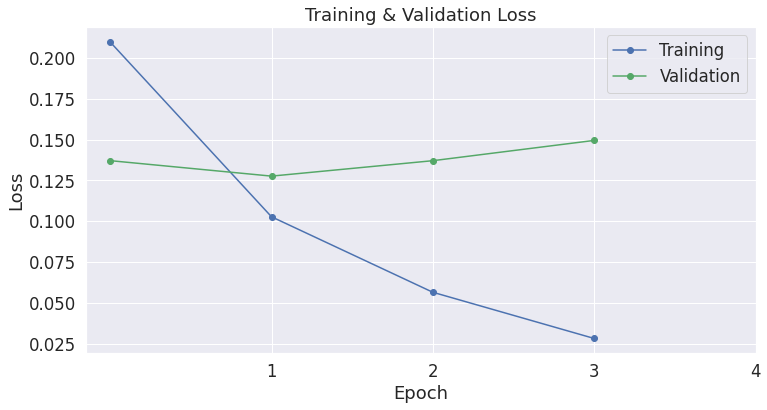

In [65]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

df_stats = pd.DataFrame(data=training_stats)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#In the future, if you want to continue to work on this model, you can load it back in.
checkpoint = torch.load(output_file, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [130]:
# test
model.eval()

sent="Perfect tracking medications. The ability build medication profiles others great. Also able search identify pills"

test_dataset = generate_input([sent], None)

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  if len(batch) == 3:
    b_input_ids, b_input_mask, b_labels = batch
  else:
    b_input_ids, b_input_mask = batch

  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    print(pred_flat)


[1]
